In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import re

import keras
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [2]:
train_file = "train.csv"
test_file = "test.csv"

train_df = pd.read_csv(train_file, index_col = 0, dtype={"Age": np.float64})
test_df = pd.read_csv(test_file, index_col = 0, dtype={"Age": np.float64})

train_df['train'] = True
test_df['train'] = False
test_df['Survived'] = None
df = pd.concat([train_df, test_df], sort=False)
del train_df
del test_df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
Survived    891 non-null object
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
train       1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 124.0+ KB


In [4]:
#drop useless ticket column
df = df.drop(columns = 'Ticket')

# drop non_embarked people and the missing fare
df = df.dropna(how='all', subset = ['Embarked'])
df = df.dropna(how='all', subset = ['Fare'])

#fill age
df['Age'] = df['Age'].fillna(value = df['Age'].median())

#nb of training exemples
m = df.shape[0]

#find the Surname to det families
df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
#find the name length
df["Name_len"] = df["Name"].apply(lambda x: len(x))

#add total nb of relatives on the boat
df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['Family_size'] = pd.cut(df['Family_size'], bins=[0,1,4,20], labels=[0,1,2])

#find the title
df['Title'] = df['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Dr": 5, "Rev": 6,
                 "Major": 7, "Col": 7, "Mlle": 2,
                 "Mme": 3,"Don": 9,"Dona": 9,
                 "Lady": 10, "Countess": 10,
                 "Jonkheer": 10, "Sir": 9,
                 "Capt": 7, "Ms": 2}
df["Title"] = df.loc[:,'Title'].map(title_mapping)


#create an index for the cabin, after sorting since similar numbers should be close
tmp_df = df
df = df.sort_values(by = 'Cabin')
le1 = preprocessing.LabelEncoder()
le1.fit(df['Cabin'].values.astype(str))
df['Cabin'] = le1.transform(df['Cabin'].values.astype(str))
df = df.reset_index()
df = df.set_index('PassengerId')

#create an index for each family by comparing Surname and numbers giving relatives
le2 = preprocessing.LabelEncoder()
arrays = [df['SibSp'].values, df['Parch'].values, df['Surname'].values]
joint_criterias = [str(arrays[0][i]) + str(arrays[1][i]) + str(arrays[2][i]) for i in range(m)]
le2.fit(joint_criterias)
df['Family_ind'] = le2.transform(joint_criterias)

#index for the departing port, the sex and the surname while we use it
cols = ['Embarked', 'Sex', 'Surname']
encoders = []
for col in cols:    
    le = preprocessing.LabelEncoder()
    le.fit(df[col].values.astype(str))
    df[col] = le.transform(df[col].values.astype(str))
    encoders.append(le)

#add mean, min and max age of the family
df['Mean_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.mean())
df['Min_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.min())
df['Max_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.max())

#name as well as family are no longer useful, since information is now contained elsewhere ??? essayons avec d'abord puis sans
df = df.drop(columns = ['Name', 'SibSp', 'Parch'])

#normalize the rest of the Data ?

In [5]:
print(df.tail(5))

            Survived  Pclass  Sex   Age     Fare  Cabin  Embarked  train  \
PassengerId                                                                
1304            None       3    0  28.0   7.7750    185         2  False   
1305            None       3    1  28.0   8.0500    185         2  False   
1307            None       3    1  38.5   7.2500    185         2  False   
1308            None       3    1  28.0   8.0500    185         2  False   
1309            None       3    1  28.0  22.3583    185         0  False   

             Surname  Name_len Family_size  Title  Family_ind  Mean_age  \
PassengerId                                                               
1304             338        30           0      2         265      28.0   
1305             757        18           0      1         607      28.0   
1307             703        28           0      1         562      38.5   
1308             831        19           0      1         666      29.5   
1309             

In [11]:
train_df = df.loc[lambda df:df['train'] == True].drop(columns = 'train')
test_df = df.loc[lambda df:df['train'] == False].drop(columns = 'train')

y = train_df['Survived'].astype(bool).values
X = train_df.drop(columns = 'Survived').values

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=700, verbose=1, max_depth=3)
model1.fit(X_tr, y_tr)
print(model1.score(X_tr, y_tr))
print(model1.score(X_val, y_val))

      Iter       Train Loss   Remaining Time 
         1           1.2948            1.41s
         2           1.2536            1.22s
         3           1.2161            1.19s
         4           1.1823            1.17s
         5           1.1514            1.16s
         6           1.1199            1.15s
         7           1.0916            1.13s
         8           1.0652            1.12s
         9           1.0414            1.11s
        10           1.0191            1.10s
        20           0.8723            0.96s
        30           0.7964            0.87s
        40           0.7387            0.83s
        50           0.7002            0.79s
        60           0.6711            0.77s
        70           0.6458            0.74s
        80           0.6248            0.72s
        90           0.6013            0.69s
       100           0.5863            0.68s
       200           0.4500            0.53s
       300           0.3479            0.42s
       40

Pclass = 0.06553046817674767
Sex = 0.015116693553828494
Age = 0.02789880274224512
Fare = 0.11298122419949336
Cabin = 0.06151458692970876
Embarked = 0.01614640239034378
Surname = 0.08324191427444988
Name_len = 0.055111338732393635
Family_size = 0.04781647048897658
Title = 0.37112410957723396
Family_ind = 0.07526642027525793
Mean_age = 0.019498353210520934
Min_age = 0.027950568739312478
Max_age = 0.020802646709487328


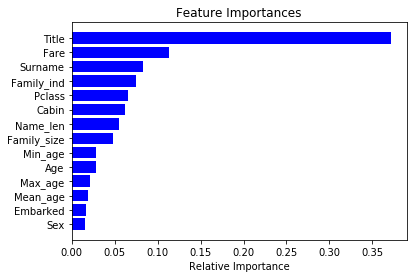

In [8]:
features = X_tr.columns.values
importances = model1.feature_importances_
indices = np.argsort(importances)

for name, importance in zip(features, importances):
    print(name, "=", importance)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
def create_model(optimizer='Adam'):

    input_dim = X_tr.shape[1]

    l2 = regularizers.l2(0.01)

    model2 = Sequential()
    model2.add(Dense(32, activation = 'relu', kernel_initializer='glorot_normal', input_dim=input_dim, kernel_regularizer=l2))
    model2.add(Dense(64, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(128, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(164, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(16, activation = 'relu', kernel_initializer='glorot_normal'))
    model2.add(Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal'))

    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model2

histories = []
models = []
kf = KFold(10, random_state=42)
for train_ind, test_ind in kf.split(X):
    X_tr, X_test = X[train_ind], X[test_ind]
    y_tr, y_test = y[train_ind], y[test_ind]
    model = create_model()
    history = model.fit(X_tr, y_tr, batch_size=32, epochs=10000, validation_data=(X_val,y_val))
    models.append(model)
    histories.append(history)

Train on 800 samples, validate on 178 samples
Epoch 1/10000
800/800 [==============================] - 2s 2ms/step - loss: 3.3201 - acc: 0.6250 - val_loss: 2.9199 - val_acc: 0.6629
Epoch 2/10000
800/800 [==============================] - 0s 147us/step - loss: 2.6822 - acc: 0.6450 - val_loss: 2.4506 - val_acc: 0.6629
Epoch 3/10000
800/800 [==============================] - 0s 148us/step - loss: 2.3078 - acc: 0.6450 - val_loss: 2.1557 - val_acc: 0.6629
Epoch 4/10000
800/800 [==============================] - 0s 155us/step - loss: 2.0202 - acc: 0.6450 - val_loss: 1.8692 - val_acc: 0.6685
Epoch 5/10000
800/800 [==============================] - 0s 155us/step - loss: 1.8136 - acc: 0.6450 - val_loss: 1.7059 - val_acc: 0.6685
Epoch 6/10000
800/800 [==============================] - 0s 145us/step - loss: 1.6705 - acc: 0.6450 - val_loss: 1.5822 - val_acc: 0.6629
Epoch 7/10000
800/800 [==============================] - 0s 156us/step - loss: 1.5606 - acc: 0.6450 - val_loss: 1.5025 - val_acc: 0.66

800/800 [==============================] - 0s 155us/step - loss: 0.7228 - acc: 0.6450 - val_loss: 0.6936 - val_acc: 0.6629
Epoch 61/10000
800/800 [==============================] - 0s 150us/step - loss: 0.7206 - acc: 0.6450 - val_loss: 0.6901 - val_acc: 0.6629
Epoch 62/10000
800/800 [==============================] - 0s 150us/step - loss: 0.7145 - acc: 0.6450 - val_loss: 0.6958 - val_acc: 0.6629
Epoch 63/10000
800/800 [==============================] - 0s 136us/step - loss: 0.7136 - acc: 0.6525 - val_loss: 0.6803 - val_acc: 0.6629
Epoch 64/10000
800/800 [==============================] - 0s 148us/step - loss: 0.7122 - acc: 0.6525 - val_loss: 0.6817 - val_acc: 0.6910
Epoch 65/10000
800/800 [==============================] - 0s 165us/step - loss: 0.7178 - acc: 0.6562 - val_loss: 0.6792 - val_acc: 0.6798
Epoch 66/10000
800/800 [==============================] - 0s 154us/step - loss: 0.7028 - acc: 0.6613 - val_loss: 0.6785 - val_acc: 0.6854
Epoch 67/10000
800/800 [=========================

800/800 [==============================] - 0s 177us/step - loss: 0.6182 - acc: 0.6950 - val_loss: 0.6030 - val_acc: 0.6966
Epoch 120/10000
800/800 [==============================] - 0s 141us/step - loss: 0.6117 - acc: 0.7063 - val_loss: 0.5884 - val_acc: 0.7360
Epoch 121/10000
800/800 [==============================] - 0s 158us/step - loss: 0.6106 - acc: 0.7100 - val_loss: 0.6060 - val_acc: 0.7079
Epoch 122/10000
800/800 [==============================] - 0s 143us/step - loss: 0.6022 - acc: 0.7225 - val_loss: 0.5888 - val_acc: 0.7247
Epoch 123/10000
800/800 [==============================] - 0s 142us/step - loss: 0.5985 - acc: 0.7225 - val_loss: 0.5879 - val_acc: 0.7022
Epoch 124/10000
800/800 [==============================] - 0s 141us/step - loss: 0.6066 - acc: 0.7150 - val_loss: 0.5903 - val_acc: 0.7191
Epoch 125/10000
800/800 [==============================] - 0s 142us/step - loss: 0.6016 - acc: 0.7162 - val_loss: 0.6056 - val_acc: 0.7079
Epoch 126/10000
800/800 [==================

800/800 [==============================] - 0s 154us/step - loss: 0.5788 - acc: 0.7263 - val_loss: 0.5748 - val_acc: 0.7303
Epoch 179/10000
800/800 [==============================] - 0s 142us/step - loss: 0.5763 - acc: 0.7238 - val_loss: 0.5730 - val_acc: 0.7303
Epoch 180/10000
800/800 [==============================] - 0s 187us/step - loss: 0.5681 - acc: 0.7462 - val_loss: 0.5678 - val_acc: 0.7247
Epoch 181/10000
800/800 [==============================] - 0s 145us/step - loss: 0.5805 - acc: 0.7338 - val_loss: 0.5750 - val_acc: 0.7360
Epoch 182/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5767 - acc: 0.7250 - val_loss: 0.6419 - val_acc: 0.6798
Epoch 183/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5872 - acc: 0.7300 - val_loss: 0.5734 - val_acc: 0.7360
Epoch 184/10000
800/800 [==============================] - 0s 136us/step - loss: 0.5748 - acc: 0.7300 - val_loss: 0.5751 - val_acc: 0.7303
Epoch 185/10000
800/800 [==================

800/800 [==============================] - 0s 131us/step - loss: 0.5558 - acc: 0.7475 - val_loss: 0.5776 - val_acc: 0.7416
Epoch 238/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5655 - acc: 0.7375 - val_loss: 0.5999 - val_acc: 0.7416
Epoch 239/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5790 - acc: 0.7325 - val_loss: 0.5698 - val_acc: 0.7528
Epoch 240/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5644 - acc: 0.7325 - val_loss: 0.5967 - val_acc: 0.7416
Epoch 241/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5584 - acc: 0.7600 - val_loss: 0.5751 - val_acc: 0.7360
Epoch 242/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5597 - acc: 0.7413 - val_loss: 0.5629 - val_acc: 0.7303
Epoch 243/10000
800/800 [==============================] - 0s 136us/step - loss: 0.5639 - acc: 0.7312 - val_loss: 0.6589 - val_acc: 0.7022
Epoch 244/10000
800/800 [==================

800/800 [==============================] - 0s 135us/step - loss: 0.5535 - acc: 0.7600 - val_loss: 0.6016 - val_acc: 0.7135
Epoch 297/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5586 - acc: 0.7388 - val_loss: 0.5725 - val_acc: 0.7303
Epoch 298/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5558 - acc: 0.7500 - val_loss: 0.5672 - val_acc: 0.7303
Epoch 299/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5589 - acc: 0.7413 - val_loss: 0.5626 - val_acc: 0.7416
Epoch 300/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5643 - acc: 0.7500 - val_loss: 0.5638 - val_acc: 0.7416
Epoch 301/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5539 - acc: 0.7600 - val_loss: 0.5864 - val_acc: 0.7303
Epoch 302/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5536 - acc: 0.7638 - val_loss: 0.5664 - val_acc: 0.7472
Epoch 303/10000
800/800 [==================

800/800 [==============================] - 0s 132us/step - loss: 0.5466 - acc: 0.7538 - val_loss: 0.5734 - val_acc: 0.7584
Epoch 356/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5416 - acc: 0.7550 - val_loss: 0.5769 - val_acc: 0.7528
Epoch 357/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5457 - acc: 0.7587 - val_loss: 0.5596 - val_acc: 0.7584
Epoch 358/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5461 - acc: 0.7512 - val_loss: 0.5677 - val_acc: 0.7416
Epoch 359/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5527 - acc: 0.7475 - val_loss: 0.5945 - val_acc: 0.7584
Epoch 360/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5395 - acc: 0.7600 - val_loss: 0.5725 - val_acc: 0.7360
Epoch 361/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5423 - acc: 0.7600 - val_loss: 0.5815 - val_acc: 0.7472
Epoch 362/10000
800/800 [==================

800/800 [==============================] - 0s 135us/step - loss: 0.5424 - acc: 0.7625 - val_loss: 0.5603 - val_acc: 0.7528
Epoch 415/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5372 - acc: 0.7612 - val_loss: 0.5665 - val_acc: 0.7416
Epoch 416/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5315 - acc: 0.7688 - val_loss: 0.5892 - val_acc: 0.7416
Epoch 417/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5329 - acc: 0.7638 - val_loss: 0.5657 - val_acc: 0.7528
Epoch 418/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5519 - acc: 0.7575 - val_loss: 0.5697 - val_acc: 0.7528
Epoch 419/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5454 - acc: 0.7612 - val_loss: 0.5723 - val_acc: 0.7528
Epoch 420/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5396 - acc: 0.7625 - val_loss: 0.5647 - val_acc: 0.7584
Epoch 421/10000
800/800 [==================

800/800 [==============================] - 0s 134us/step - loss: 0.5406 - acc: 0.7538 - val_loss: 0.5894 - val_acc: 0.7135
Epoch 474/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5530 - acc: 0.7338 - val_loss: 0.6893 - val_acc: 0.6910
Epoch 475/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5524 - acc: 0.7525 - val_loss: 0.5741 - val_acc: 0.7528
Epoch 476/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5512 - acc: 0.7638 - val_loss: 0.5593 - val_acc: 0.7528
Epoch 477/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5483 - acc: 0.7338 - val_loss: 0.5718 - val_acc: 0.7247
Epoch 478/10000
800/800 [==============================] - 0s 135us/step - loss: 0.5432 - acc: 0.7525 - val_loss: 0.5722 - val_acc: 0.7472
Epoch 479/10000
800/800 [==============================] - 0s 135us/step - loss: 0.5432 - acc: 0.7512 - val_loss: 0.5565 - val_acc: 0.7472
Epoch 480/10000
800/800 [==================

800/800 [==============================] - 0s 129us/step - loss: 0.5368 - acc: 0.7525 - val_loss: 0.5814 - val_acc: 0.7528
Epoch 533/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5305 - acc: 0.7675 - val_loss: 0.5647 - val_acc: 0.7416
Epoch 534/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5237 - acc: 0.7625 - val_loss: 0.5770 - val_acc: 0.7528
Epoch 535/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5218 - acc: 0.7750 - val_loss: 0.5689 - val_acc: 0.7416
Epoch 536/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5551 - acc: 0.7462 - val_loss: 0.6058 - val_acc: 0.7584
Epoch 537/10000
800/800 [==============================] - 0s 137us/step - loss: 0.5242 - acc: 0.7825 - val_loss: 0.5698 - val_acc: 0.7697
Epoch 538/10000
800/800 [==============================] - 0s 135us/step - loss: 0.5411 - acc: 0.7500 - val_loss: 0.5846 - val_acc: 0.7416
Epoch 539/10000
800/800 [==================

800/800 [==============================] - 0s 135us/step - loss: 0.5276 - acc: 0.7587 - val_loss: 0.5880 - val_acc: 0.7191
Epoch 592/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5246 - acc: 0.7737 - val_loss: 0.5682 - val_acc: 0.7528
Epoch 593/10000
800/800 [==============================] - 0s 128us/step - loss: 0.5181 - acc: 0.7762 - val_loss: 0.5659 - val_acc: 0.7472
Epoch 594/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5458 - acc: 0.7512 - val_loss: 0.5840 - val_acc: 0.7584
Epoch 595/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5252 - acc: 0.7675 - val_loss: 0.5862 - val_acc: 0.7640
Epoch 596/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5180 - acc: 0.7875 - val_loss: 0.5815 - val_acc: 0.7528
Epoch 597/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5215 - acc: 0.7725 - val_loss: 0.5719 - val_acc: 0.7697
Epoch 598/10000
800/800 [==================

800/800 [==============================] - 0s 131us/step - loss: 0.5207 - acc: 0.7762 - val_loss: 0.5714 - val_acc: 0.7640
Epoch 651/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5377 - acc: 0.7725 - val_loss: 0.6732 - val_acc: 0.7079
Epoch 652/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5176 - acc: 0.7787 - val_loss: 0.5951 - val_acc: 0.7472
Epoch 653/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5117 - acc: 0.7850 - val_loss: 0.5882 - val_acc: 0.7640
Epoch 654/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5049 - acc: 0.7913 - val_loss: 0.5818 - val_acc: 0.7528
Epoch 655/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5329 - acc: 0.7662 - val_loss: 0.6176 - val_acc: 0.7528
Epoch 656/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5358 - acc: 0.7625 - val_loss: 0.6306 - val_acc: 0.7247
Epoch 657/10000
800/800 [==================

800/800 [==============================] - 0s 130us/step - loss: 0.5195 - acc: 0.7762 - val_loss: 0.5703 - val_acc: 0.7640
Epoch 710/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5178 - acc: 0.7800 - val_loss: 0.5761 - val_acc: 0.7640
Epoch 711/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5160 - acc: 0.7838 - val_loss: 0.5982 - val_acc: 0.7528
Epoch 712/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5318 - acc: 0.7750 - val_loss: 0.5922 - val_acc: 0.7528
Epoch 713/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5493 - acc: 0.7638 - val_loss: 0.6356 - val_acc: 0.7528
Epoch 714/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5103 - acc: 0.7875 - val_loss: 0.5808 - val_acc: 0.7584
Epoch 715/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5316 - acc: 0.7675 - val_loss: 0.5945 - val_acc: 0.7584
Epoch 716/10000
800/800 [==================

800/800 [==============================] - 0s 133us/step - loss: 0.4982 - acc: 0.7950 - val_loss: 0.5748 - val_acc: 0.7472
Epoch 769/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5151 - acc: 0.7800 - val_loss: 0.5673 - val_acc: 0.7640
Epoch 770/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5006 - acc: 0.7875 - val_loss: 0.5885 - val_acc: 0.7640
Epoch 771/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5100 - acc: 0.7863 - val_loss: 0.5808 - val_acc: 0.7753
Epoch 772/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5090 - acc: 0.7850 - val_loss: 0.5726 - val_acc: 0.7809
Epoch 773/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5070 - acc: 0.7875 - val_loss: 0.5931 - val_acc: 0.7921
Epoch 774/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5343 - acc: 0.7712 - val_loss: 0.7094 - val_acc: 0.7191
Epoch 775/10000
800/800 [==================

800/800 [==============================] - 0s 135us/step - loss: 0.5089 - acc: 0.7800 - val_loss: 0.6465 - val_acc: 0.7640
Epoch 828/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5102 - acc: 0.7875 - val_loss: 0.5642 - val_acc: 0.7697
Epoch 829/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5077 - acc: 0.7863 - val_loss: 0.5646 - val_acc: 0.7640
Epoch 830/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4919 - acc: 0.7950 - val_loss: 0.6054 - val_acc: 0.7753
Epoch 831/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5035 - acc: 0.7888 - val_loss: 0.6609 - val_acc: 0.7528
Epoch 832/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5257 - acc: 0.7800 - val_loss: 0.6423 - val_acc: 0.7360
Epoch 833/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5268 - acc: 0.7737 - val_loss: 0.5733 - val_acc: 0.7584
Epoch 834/10000
800/800 [==================

800/800 [==============================] - 0s 130us/step - loss: 0.5033 - acc: 0.7925 - val_loss: 0.5761 - val_acc: 0.7978
Epoch 887/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5018 - acc: 0.7963 - val_loss: 0.6064 - val_acc: 0.7472
Epoch 888/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5274 - acc: 0.7762 - val_loss: 0.5689 - val_acc: 0.7753
Epoch 889/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4908 - acc: 0.8062 - val_loss: 0.5767 - val_acc: 0.7697
Epoch 890/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4943 - acc: 0.8100 - val_loss: 0.5683 - val_acc: 0.7753
Epoch 891/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5070 - acc: 0.7775 - val_loss: 0.5734 - val_acc: 0.7753
Epoch 892/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4983 - acc: 0.7925 - val_loss: 0.6534 - val_acc: 0.7303
Epoch 893/10000
800/800 [==================

800/800 [==============================] - 0s 132us/step - loss: 0.5514 - acc: 0.7587 - val_loss: 0.5803 - val_acc: 0.8202
Epoch 946/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4930 - acc: 0.8087 - val_loss: 0.5757 - val_acc: 0.7865
Epoch 947/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5119 - acc: 0.7900 - val_loss: 0.5966 - val_acc: 0.7697
Epoch 948/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5454 - acc: 0.7638 - val_loss: 0.5619 - val_acc: 0.7978
Epoch 949/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4849 - acc: 0.8125 - val_loss: 0.5646 - val_acc: 0.7528
Epoch 950/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5025 - acc: 0.7800 - val_loss: 0.5637 - val_acc: 0.7697
Epoch 951/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4927 - acc: 0.7963 - val_loss: 0.5686 - val_acc: 0.7809
Epoch 952/10000
800/800 [==================

800/800 [==============================] - 0s 131us/step - loss: 0.4878 - acc: 0.8038 - val_loss: 0.5673 - val_acc: 0.7809
Epoch 1005/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5022 - acc: 0.7963 - val_loss: 0.6041 - val_acc: 0.7921
Epoch 1006/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5105 - acc: 0.8013 - val_loss: 0.5667 - val_acc: 0.8146
Epoch 1007/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4753 - acc: 0.8113 - val_loss: 0.7257 - val_acc: 0.6910
Epoch 1008/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5153 - acc: 0.7725 - val_loss: 0.5869 - val_acc: 0.7640
Epoch 1009/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5068 - acc: 0.7963 - val_loss: 0.6298 - val_acc: 0.7809
Epoch 1010/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4802 - acc: 0.8062 - val_loss: 0.5682 - val_acc: 0.7921
Epoch 1011/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4737 - acc: 0.8113 - val_loss: 0.5760 - val_acc: 0.8034
Epoch 1063/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4828 - acc: 0.8125 - val_loss: 0.5771 - val_acc: 0.8146
Epoch 1064/10000
800/800 [==============================] - 0s 127us/step - loss: 0.4700 - acc: 0.8212 - val_loss: 0.5695 - val_acc: 0.8202
Epoch 1065/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4923 - acc: 0.7875 - val_loss: 0.5756 - val_acc: 0.7809
Epoch 1066/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5096 - acc: 0.7913 - val_loss: 0.6122 - val_acc: 0.7753
Epoch 1067/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5355 - acc: 0.7675 - val_loss: 0.5752 - val_acc: 0.7978
Epoch 1068/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5010 - acc: 0.7913 - val_loss: 0.5582 - val_acc: 0.8034
Epoch 1069/10000
800/800 [===========

800/800 [==============================] - 0s 129us/step - loss: 0.4883 - acc: 0.8000 - val_loss: 0.5685 - val_acc: 0.8315
Epoch 1121/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4764 - acc: 0.8225 - val_loss: 0.5851 - val_acc: 0.7921
Epoch 1122/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5557 - acc: 0.7600 - val_loss: 0.5653 - val_acc: 0.7865
Epoch 1123/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5323 - acc: 0.7875 - val_loss: 0.5793 - val_acc: 0.7978
Epoch 1124/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4801 - acc: 0.8113 - val_loss: 0.5656 - val_acc: 0.7865
Epoch 1125/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4861 - acc: 0.8087 - val_loss: 0.5686 - val_acc: 0.7921
Epoch 1126/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5384 - acc: 0.7762 - val_loss: 0.5873 - val_acc: 0.7865
Epoch 1127/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.5051 - acc: 0.7787 - val_loss: 0.5549 - val_acc: 0.7978
Epoch 1179/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4912 - acc: 0.7963 - val_loss: 0.5595 - val_acc: 0.8146
Epoch 1180/10000
800/800 [==============================] - 0s 127us/step - loss: 0.5076 - acc: 0.7762 - val_loss: 0.8024 - val_acc: 0.7247
Epoch 1181/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5173 - acc: 0.7913 - val_loss: 0.5533 - val_acc: 0.8146
Epoch 1182/10000
800/800 [==============================] - 0s 136us/step - loss: 0.4830 - acc: 0.8100 - val_loss: 0.6154 - val_acc: 0.7809
Epoch 1183/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4872 - acc: 0.8013 - val_loss: 0.5559 - val_acc: 0.8090
Epoch 1184/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4847 - acc: 0.8225 - val_loss: 0.5904 - val_acc: 0.7921
Epoch 1185/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4736 - acc: 0.8087 - val_loss: 0.5792 - val_acc: 0.7865
Epoch 1237/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4837 - acc: 0.8075 - val_loss: 0.6082 - val_acc: 0.7921
Epoch 1238/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4693 - acc: 0.8188 - val_loss: 0.5808 - val_acc: 0.8090
Epoch 1239/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4675 - acc: 0.8163 - val_loss: 0.5664 - val_acc: 0.8034
Epoch 1240/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4822 - acc: 0.8075 - val_loss: 0.5816 - val_acc: 0.7978
Epoch 1241/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4967 - acc: 0.7900 - val_loss: 0.5581 - val_acc: 0.8371
Epoch 1242/10000
800/800 [==============================] - 0s 134us/step - loss: 0.5219 - acc: 0.7700 - val_loss: 0.5616 - val_acc: 0.8146
Epoch 1243/10000
800/800 [===========

800/800 [==============================] - 0s 154us/step - loss: 0.4839 - acc: 0.8050 - val_loss: 0.6001 - val_acc: 0.7809
Epoch 1295/10000
800/800 [==============================] - 0s 151us/step - loss: 0.4795 - acc: 0.8212 - val_loss: 0.5685 - val_acc: 0.8034
Epoch 1296/10000
800/800 [==============================] - 0s 161us/step - loss: 0.4773 - acc: 0.8100 - val_loss: 0.5739 - val_acc: 0.8034
Epoch 1297/10000
800/800 [==============================] - 0s 151us/step - loss: 0.4795 - acc: 0.8050 - val_loss: 0.5757 - val_acc: 0.7921
Epoch 1298/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4706 - acc: 0.8125 - val_loss: 0.6074 - val_acc: 0.7978
Epoch 1299/10000
800/800 [==============================] - 0s 140us/step - loss: 0.4663 - acc: 0.8175 - val_loss: 0.5758 - val_acc: 0.7865
Epoch 1300/10000
800/800 [==============================] - 0s 155us/step - loss: 0.4890 - acc: 0.8050 - val_loss: 0.5589 - val_acc: 0.8034
Epoch 1301/10000
800/800 [===========

800/800 [==============================] - 0s 135us/step - loss: 0.4771 - acc: 0.8150 - val_loss: 0.5654 - val_acc: 0.8146
Epoch 1353/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4992 - acc: 0.7913 - val_loss: 0.6630 - val_acc: 0.7584
Epoch 1354/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4853 - acc: 0.7875 - val_loss: 0.5855 - val_acc: 0.8090
Epoch 1355/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4694 - acc: 0.8137 - val_loss: 0.5816 - val_acc: 0.8146
Epoch 1356/10000
800/800 [==============================] - 0s 130us/step - loss: 0.5029 - acc: 0.7950 - val_loss: 0.7271 - val_acc: 0.7079
Epoch 1357/10000
800/800 [==============================] - 0s 136us/step - loss: 0.5242 - acc: 0.7825 - val_loss: 0.5890 - val_acc: 0.7921
Epoch 1358/10000
800/800 [==============================] - 0s 136us/step - loss: 0.4902 - acc: 0.7925 - val_loss: 0.5647 - val_acc: 0.8034
Epoch 1359/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4617 - acc: 0.8087 - val_loss: 0.5619 - val_acc: 0.8202
Epoch 1411/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4628 - acc: 0.8212 - val_loss: 0.5692 - val_acc: 0.8315
Epoch 1412/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4526 - acc: 0.8337 - val_loss: 0.5810 - val_acc: 0.8146
Epoch 1413/10000
800/800 [==============================] - 0s 137us/step - loss: 0.4618 - acc: 0.8137 - val_loss: 0.5850 - val_acc: 0.8258
Epoch 1414/10000
800/800 [==============================] - 0s 165us/step - loss: 0.4695 - acc: 0.8163 - val_loss: 0.5736 - val_acc: 0.8090
Epoch 1415/10000
800/800 [==============================] - 0s 156us/step - loss: 0.4950 - acc: 0.8038 - val_loss: 0.5956 - val_acc: 0.8146
Epoch 1416/10000
800/800 [==============================] - 0s 160us/step - loss: 0.4686 - acc: 0.8125 - val_loss: 0.5642 - val_acc: 0.8034
Epoch 1417/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4618 - acc: 0.8212 - val_loss: 0.5578 - val_acc: 0.8090
Epoch 1469/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4713 - acc: 0.8175 - val_loss: 0.5955 - val_acc: 0.7697
Epoch 1470/10000
800/800 [==============================] - 0s 154us/step - loss: 0.4792 - acc: 0.8175 - val_loss: 0.5806 - val_acc: 0.8090
Epoch 1471/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5015 - acc: 0.7987 - val_loss: 0.5665 - val_acc: 0.8202
Epoch 1472/10000
800/800 [==============================] - 0s 144us/step - loss: 0.4655 - acc: 0.8225 - val_loss: 0.5634 - val_acc: 0.7978
Epoch 1473/10000
800/800 [==============================] - 0s 140us/step - loss: 0.4752 - acc: 0.8038 - val_loss: 0.5655 - val_acc: 0.8258
Epoch 1474/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4654 - acc: 0.8163 - val_loss: 0.6195 - val_acc: 0.7697
Epoch 1475/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.5458 - acc: 0.7800 - val_loss: 0.7350 - val_acc: 0.7135
Epoch 1527/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4932 - acc: 0.8025 - val_loss: 0.5919 - val_acc: 0.7697
Epoch 1528/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4588 - acc: 0.8225 - val_loss: 0.6372 - val_acc: 0.7809
Epoch 1529/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4741 - acc: 0.8113 - val_loss: 0.5871 - val_acc: 0.8090
Epoch 1530/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4485 - acc: 0.8362 - val_loss: 0.5653 - val_acc: 0.8315
Epoch 1531/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4574 - acc: 0.8275 - val_loss: 0.5659 - val_acc: 0.8202
Epoch 1532/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4518 - acc: 0.8263 - val_loss: 0.5747 - val_acc: 0.8258
Epoch 1533/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4700 - acc: 0.8075 - val_loss: 0.5810 - val_acc: 0.8090
Epoch 1585/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4618 - acc: 0.8263 - val_loss: 0.5638 - val_acc: 0.8315
Epoch 1586/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4450 - acc: 0.8425 - val_loss: 0.5642 - val_acc: 0.8202
Epoch 1587/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4474 - acc: 0.8325 - val_loss: 0.5642 - val_acc: 0.8258
Epoch 1588/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4618 - acc: 0.8175 - val_loss: 0.5730 - val_acc: 0.8258
Epoch 1589/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4487 - acc: 0.8275 - val_loss: 0.6241 - val_acc: 0.7753
Epoch 1590/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4670 - acc: 0.8163 - val_loss: 0.6329 - val_acc: 0.8034
Epoch 1591/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4486 - acc: 0.8412 - val_loss: 0.5687 - val_acc: 0.8146
Epoch 1643/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4772 - acc: 0.8087 - val_loss: 0.6503 - val_acc: 0.7697
Epoch 1644/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4796 - acc: 0.8150 - val_loss: 0.5845 - val_acc: 0.8090
Epoch 1645/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4497 - acc: 0.8313 - val_loss: 0.5706 - val_acc: 0.7978
Epoch 1646/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4385 - acc: 0.8350 - val_loss: 0.6132 - val_acc: 0.7921
Epoch 1647/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4912 - acc: 0.8137 - val_loss: 0.5689 - val_acc: 0.8034
Epoch 1648/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4586 - acc: 0.8263 - val_loss: 0.5884 - val_acc: 0.8258
Epoch 1649/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4751 - acc: 0.8100 - val_loss: 0.5588 - val_acc: 0.8315
Epoch 1701/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4758 - acc: 0.8163 - val_loss: 0.5760 - val_acc: 0.8258
Epoch 1702/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4484 - acc: 0.8362 - val_loss: 0.5778 - val_acc: 0.8371
Epoch 1703/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4415 - acc: 0.8400 - val_loss: 0.5847 - val_acc: 0.8202
Epoch 1704/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4880 - acc: 0.8113 - val_loss: 0.5973 - val_acc: 0.8146
Epoch 1705/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4590 - acc: 0.8250 - val_loss: 0.7416 - val_acc: 0.7303
Epoch 1706/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4758 - acc: 0.8125 - val_loss: 0.5770 - val_acc: 0.8146
Epoch 1707/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4500 - acc: 0.8313 - val_loss: 0.6199 - val_acc: 0.7921
Epoch 1759/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4525 - acc: 0.8263 - val_loss: 0.6128 - val_acc: 0.8090
Epoch 1760/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4564 - acc: 0.8313 - val_loss: 0.5732 - val_acc: 0.8315
Epoch 1761/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4845 - acc: 0.8100 - val_loss: 0.6644 - val_acc: 0.7753
Epoch 1762/10000
800/800 [==============================] - 0s 128us/step - loss: 0.4555 - acc: 0.8250 - val_loss: 0.5660 - val_acc: 0.7921
Epoch 1763/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4658 - acc: 0.8300 - val_loss: 0.6091 - val_acc: 0.7978
Epoch 1764/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4517 - acc: 0.8337 - val_loss: 0.5941 - val_acc: 0.8146
Epoch 1765/10000
800/800 [===========

800/800 [==============================] - 0s 135us/step - loss: 0.4711 - acc: 0.8188 - val_loss: 0.6403 - val_acc: 0.7865
Epoch 1817/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4612 - acc: 0.8087 - val_loss: 0.5790 - val_acc: 0.8315
Epoch 1818/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4382 - acc: 0.8425 - val_loss: 0.6228 - val_acc: 0.7640
Epoch 1819/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4525 - acc: 0.8212 - val_loss: 0.5618 - val_acc: 0.8202
Epoch 1820/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4506 - acc: 0.8313 - val_loss: 0.5796 - val_acc: 0.8034
Epoch 1821/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4552 - acc: 0.8313 - val_loss: 0.5559 - val_acc: 0.8202
Epoch 1822/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4656 - acc: 0.8175 - val_loss: 0.6873 - val_acc: 0.7416
Epoch 1823/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4470 - acc: 0.8325 - val_loss: 0.5796 - val_acc: 0.8202
Epoch 1875/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4317 - acc: 0.8313 - val_loss: 0.5589 - val_acc: 0.8483
Epoch 1876/10000
800/800 [==============================] - 0s 136us/step - loss: 0.4411 - acc: 0.8538 - val_loss: 0.5812 - val_acc: 0.7978
Epoch 1877/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4588 - acc: 0.8300 - val_loss: 0.5804 - val_acc: 0.7921
Epoch 1878/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4455 - acc: 0.8500 - val_loss: 0.5610 - val_acc: 0.8315
Epoch 1879/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4696 - acc: 0.8113 - val_loss: 0.5748 - val_acc: 0.8315
Epoch 1880/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4660 - acc: 0.8125 - val_loss: 0.6332 - val_acc: 0.8034
Epoch 1881/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4502 - acc: 0.8275 - val_loss: 0.5787 - val_acc: 0.7921
Epoch 1933/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4424 - acc: 0.8375 - val_loss: 0.5678 - val_acc: 0.8258
Epoch 1934/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4351 - acc: 0.8425 - val_loss: 0.5662 - val_acc: 0.8202
Epoch 1935/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4651 - acc: 0.8175 - val_loss: 0.5969 - val_acc: 0.7921
Epoch 1936/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4449 - acc: 0.8337 - val_loss: 0.6350 - val_acc: 0.7809
Epoch 1937/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4642 - acc: 0.8200 - val_loss: 0.5548 - val_acc: 0.8258
Epoch 1938/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4747 - acc: 0.8163 - val_loss: 0.5780 - val_acc: 0.8034
Epoch 1939/10000
800/800 [===========

800/800 [==============================] - 0s 141us/step - loss: 0.4452 - acc: 0.8400 - val_loss: 0.5770 - val_acc: 0.8034
Epoch 1991/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4513 - acc: 0.8362 - val_loss: 0.5627 - val_acc: 0.8202
Epoch 1992/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4898 - acc: 0.8163 - val_loss: 0.5836 - val_acc: 0.8371
Epoch 1993/10000
800/800 [==============================] - 0s 128us/step - loss: 0.4561 - acc: 0.8300 - val_loss: 0.5728 - val_acc: 0.8258
Epoch 1994/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4498 - acc: 0.8225 - val_loss: 0.5560 - val_acc: 0.8146
Epoch 1995/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4418 - acc: 0.8337 - val_loss: 0.5591 - val_acc: 0.8146
Epoch 1996/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4695 - acc: 0.8188 - val_loss: 0.5547 - val_acc: 0.8090
Epoch 1997/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4555 - acc: 0.8188 - val_loss: 0.5487 - val_acc: 0.8090
Epoch 2049/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4372 - acc: 0.8412 - val_loss: 0.5493 - val_acc: 0.8315
Epoch 2050/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4666 - acc: 0.8100 - val_loss: 0.5385 - val_acc: 0.8258
Epoch 2051/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5025 - acc: 0.8000 - val_loss: 0.5591 - val_acc: 0.8202
Epoch 2052/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4597 - acc: 0.8287 - val_loss: 0.5877 - val_acc: 0.8090
Epoch 2053/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4421 - acc: 0.8362 - val_loss: 0.5355 - val_acc: 0.8371
Epoch 2054/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4487 - acc: 0.8337 - val_loss: 0.5584 - val_acc: 0.8315
Epoch 2055/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4702 - acc: 0.8188 - val_loss: 0.5393 - val_acc: 0.8427
Epoch 2107/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4463 - acc: 0.8275 - val_loss: 0.5601 - val_acc: 0.8315
Epoch 2108/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4449 - acc: 0.8488 - val_loss: 0.5552 - val_acc: 0.8258
Epoch 2109/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4354 - acc: 0.8412 - val_loss: 0.5460 - val_acc: 0.8539
Epoch 2110/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4342 - acc: 0.8350 - val_loss: 0.5859 - val_acc: 0.8090
Epoch 2111/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4955 - acc: 0.7987 - val_loss: 0.5455 - val_acc: 0.8034
Epoch 2112/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4951 - acc: 0.8050 - val_loss: 0.5608 - val_acc: 0.8371
Epoch 2113/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4757 - acc: 0.8125 - val_loss: 0.5443 - val_acc: 0.8371
Epoch 2165/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4322 - acc: 0.8538 - val_loss: 0.5856 - val_acc: 0.7921
Epoch 2166/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4626 - acc: 0.8200 - val_loss: 0.5831 - val_acc: 0.8090
Epoch 2167/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4412 - acc: 0.8337 - val_loss: 0.5511 - val_acc: 0.8315
Epoch 2168/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4367 - acc: 0.8450 - val_loss: 0.5909 - val_acc: 0.8034
Epoch 2169/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4300 - acc: 0.8438 - val_loss: 0.5615 - val_acc: 0.8371
Epoch 2170/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4478 - acc: 0.8313 - val_loss: 0.5891 - val_acc: 0.7865
Epoch 2171/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4777 - acc: 0.8113 - val_loss: 0.5327 - val_acc: 0.8427
Epoch 2223/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4406 - acc: 0.8325 - val_loss: 0.6144 - val_acc: 0.7978
Epoch 2224/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4468 - acc: 0.8237 - val_loss: 0.6003 - val_acc: 0.7865
Epoch 2225/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4679 - acc: 0.8300 - val_loss: 0.6306 - val_acc: 0.7753
Epoch 2226/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4700 - acc: 0.8087 - val_loss: 0.5437 - val_acc: 0.8258
Epoch 2227/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4410 - acc: 0.8287 - val_loss: 0.5476 - val_acc: 0.8202
Epoch 2228/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4515 - acc: 0.8275 - val_loss: 0.5498 - val_acc: 0.8258
Epoch 2229/10000
800/800 [===========

800/800 [==============================] - 0s 130us/step - loss: 0.4609 - acc: 0.8263 - val_loss: 0.8295 - val_acc: 0.6124
Epoch 2281/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4992 - acc: 0.8075 - val_loss: 0.5849 - val_acc: 0.8146
Epoch 2282/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4743 - acc: 0.8125 - val_loss: 0.5842 - val_acc: 0.7978
Epoch 2283/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4707 - acc: 0.8200 - val_loss: 0.5463 - val_acc: 0.8315
Epoch 2284/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4884 - acc: 0.7925 - val_loss: 0.5582 - val_acc: 0.8258
Epoch 2285/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4987 - acc: 0.7963 - val_loss: 0.5876 - val_acc: 0.8034
Epoch 2286/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4498 - acc: 0.8275 - val_loss: 0.5691 - val_acc: 0.8034
Epoch 2287/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4401 - acc: 0.8400 - val_loss: 0.5721 - val_acc: 0.8090
Epoch 2339/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4637 - acc: 0.8325 - val_loss: 0.5274 - val_acc: 0.8427
Epoch 2340/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4315 - acc: 0.8438 - val_loss: 0.5316 - val_acc: 0.8427
Epoch 2341/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4402 - acc: 0.8463 - val_loss: 0.5496 - val_acc: 0.8258
Epoch 2342/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4676 - acc: 0.8188 - val_loss: 0.6336 - val_acc: 0.7753
Epoch 2343/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4613 - acc: 0.8250 - val_loss: 0.5604 - val_acc: 0.8202
Epoch 2344/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4533 - acc: 0.8275 - val_loss: 0.7037 - val_acc: 0.7360
Epoch 2345/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4282 - acc: 0.8425 - val_loss: 0.5430 - val_acc: 0.8202
Epoch 2397/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4409 - acc: 0.8412 - val_loss: 0.5568 - val_acc: 0.8315
Epoch 2398/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4528 - acc: 0.8325 - val_loss: 0.5401 - val_acc: 0.8539
Epoch 2399/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4710 - acc: 0.8188 - val_loss: 0.5419 - val_acc: 0.8315
Epoch 2400/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4336 - acc: 0.8400 - val_loss: 0.5575 - val_acc: 0.8258
Epoch 2401/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4371 - acc: 0.8287 - val_loss: 0.5635 - val_acc: 0.8090
Epoch 2402/10000
800/800 [==============================] - 0s 133us/step - loss: 0.5155 - acc: 0.8013 - val_loss: 0.5714 - val_acc: 0.8034
Epoch 2403/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4617 - acc: 0.8325 - val_loss: 0.5384 - val_acc: 0.8146
Epoch 2455/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4394 - acc: 0.8450 - val_loss: 0.5183 - val_acc: 0.8202
Epoch 2456/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4390 - acc: 0.8263 - val_loss: 0.5365 - val_acc: 0.8202
Epoch 2457/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4355 - acc: 0.8500 - val_loss: 0.5556 - val_acc: 0.8202
Epoch 2458/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4259 - acc: 0.8575 - val_loss: 0.5445 - val_acc: 0.8034
Epoch 2459/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4336 - acc: 0.8500 - val_loss: 0.5262 - val_acc: 0.8539
Epoch 2460/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4391 - acc: 0.8263 - val_loss: 0.5786 - val_acc: 0.7865
Epoch 2461/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4643 - acc: 0.8212 - val_loss: 0.5549 - val_acc: 0.8483
Epoch 2513/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4611 - acc: 0.8300 - val_loss: 0.5328 - val_acc: 0.8596
Epoch 2514/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4497 - acc: 0.8362 - val_loss: 0.5372 - val_acc: 0.8427
Epoch 2515/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4516 - acc: 0.8225 - val_loss: 0.5786 - val_acc: 0.8034
Epoch 2516/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4215 - acc: 0.8612 - val_loss: 0.5226 - val_acc: 0.8483
Epoch 2517/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4182 - acc: 0.8475 - val_loss: 0.5632 - val_acc: 0.8202
Epoch 2518/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4673 - acc: 0.8212 - val_loss: 0.5541 - val_acc: 0.8202
Epoch 2519/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4328 - acc: 0.8488 - val_loss: 0.5347 - val_acc: 0.8427
Epoch 2571/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4175 - acc: 0.8500 - val_loss: 0.5364 - val_acc: 0.8483
Epoch 2572/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4390 - acc: 0.8362 - val_loss: 0.5433 - val_acc: 0.8427
Epoch 2573/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4313 - acc: 0.8488 - val_loss: 0.5460 - val_acc: 0.8315
Epoch 2574/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4410 - acc: 0.8300 - val_loss: 0.5642 - val_acc: 0.8202
Epoch 2575/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4423 - acc: 0.8313 - val_loss: 0.5658 - val_acc: 0.8202
Epoch 2576/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4538 - acc: 0.8300 - val_loss: 0.5493 - val_acc: 0.8371
Epoch 2577/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4275 - acc: 0.8538 - val_loss: 0.5566 - val_acc: 0.8202
Epoch 2629/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4418 - acc: 0.8375 - val_loss: 0.5233 - val_acc: 0.8371
Epoch 2630/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4221 - acc: 0.8612 - val_loss: 0.5156 - val_acc: 0.8539
Epoch 2631/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4356 - acc: 0.8488 - val_loss: 0.5231 - val_acc: 0.8315
Epoch 2632/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4241 - acc: 0.8538 - val_loss: 0.5372 - val_acc: 0.8315
Epoch 2633/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4639 - acc: 0.8225 - val_loss: 0.5129 - val_acc: 0.8652
Epoch 2634/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4192 - acc: 0.8475 - val_loss: 0.5835 - val_acc: 0.7978
Epoch 2635/10000
800/800 [===========

800/800 [==============================] - 0s 135us/step - loss: 0.4454 - acc: 0.8438 - val_loss: 0.5673 - val_acc: 0.8034
Epoch 2687/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4271 - acc: 0.8538 - val_loss: 0.5290 - val_acc: 0.8371
Epoch 2688/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4257 - acc: 0.8550 - val_loss: 0.5331 - val_acc: 0.8483
Epoch 2689/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4291 - acc: 0.8538 - val_loss: 0.5191 - val_acc: 0.8258
Epoch 2690/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4363 - acc: 0.8425 - val_loss: 0.5993 - val_acc: 0.7753
Epoch 2691/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4883 - acc: 0.8137 - val_loss: 0.5598 - val_acc: 0.7921
Epoch 2692/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5045 - acc: 0.7913 - val_loss: 0.5194 - val_acc: 0.8596
Epoch 2693/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4137 - acc: 0.8650 - val_loss: 0.6357 - val_acc: 0.7921
Epoch 2745/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4308 - acc: 0.8412 - val_loss: 0.5485 - val_acc: 0.8315
Epoch 2746/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4383 - acc: 0.8362 - val_loss: 0.5342 - val_acc: 0.8427
Epoch 2747/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4472 - acc: 0.8350 - val_loss: 0.5595 - val_acc: 0.8315
Epoch 2748/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4510 - acc: 0.8313 - val_loss: 0.6071 - val_acc: 0.7865
Epoch 2749/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4927 - acc: 0.7913 - val_loss: 0.5481 - val_acc: 0.8258
Epoch 2750/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4558 - acc: 0.8263 - val_loss: 0.5270 - val_acc: 0.8371
Epoch 2751/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4362 - acc: 0.8463 - val_loss: 0.5387 - val_acc: 0.8258
Epoch 2803/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4188 - acc: 0.8550 - val_loss: 0.5320 - val_acc: 0.8202
Epoch 2804/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4417 - acc: 0.8513 - val_loss: 0.5113 - val_acc: 0.8427
Epoch 2805/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4845 - acc: 0.8087 - val_loss: 0.5633 - val_acc: 0.8034
Epoch 2806/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4548 - acc: 0.8313 - val_loss: 0.5802 - val_acc: 0.8146
Epoch 2807/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4142 - acc: 0.8612 - val_loss: 0.5987 - val_acc: 0.7921
Epoch 2808/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4480 - acc: 0.8375 - val_loss: 0.6251 - val_acc: 0.7753
Epoch 2809/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4405 - acc: 0.8375 - val_loss: 0.6258 - val_acc: 0.7921
Epoch 2861/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4421 - acc: 0.8438 - val_loss: 0.5321 - val_acc: 0.8483
Epoch 2862/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4349 - acc: 0.8500 - val_loss: 0.5198 - val_acc: 0.8315
Epoch 2863/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4238 - acc: 0.8475 - val_loss: 0.5076 - val_acc: 0.8652
Epoch 2864/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4349 - acc: 0.8513 - val_loss: 0.5332 - val_acc: 0.8146
Epoch 2865/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4836 - acc: 0.8175 - val_loss: 0.5604 - val_acc: 0.8146
Epoch 2866/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4492 - acc: 0.8337 - val_loss: 0.5204 - val_acc: 0.8258
Epoch 2867/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4318 - acc: 0.8475 - val_loss: 0.5529 - val_acc: 0.8034
Epoch 2919/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4524 - acc: 0.8375 - val_loss: 0.5365 - val_acc: 0.8315
Epoch 2920/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4155 - acc: 0.8513 - val_loss: 0.5480 - val_acc: 0.8258
Epoch 2921/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4339 - acc: 0.8475 - val_loss: 0.5424 - val_acc: 0.8315
Epoch 2922/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4434 - acc: 0.8362 - val_loss: 0.5340 - val_acc: 0.8371
Epoch 2923/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4253 - acc: 0.8475 - val_loss: 0.5757 - val_acc: 0.8034
Epoch 2924/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4371 - acc: 0.8350 - val_loss: 0.5991 - val_acc: 0.7809
Epoch 2925/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4517 - acc: 0.8325 - val_loss: 0.5978 - val_acc: 0.8034
Epoch 2977/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4510 - acc: 0.8337 - val_loss: 0.5384 - val_acc: 0.8146
Epoch 2978/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4475 - acc: 0.8300 - val_loss: 0.5261 - val_acc: 0.8483
Epoch 2979/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4423 - acc: 0.8275 - val_loss: 0.6221 - val_acc: 0.7921
Epoch 2980/10000
800/800 [==============================] - 0s 131us/step - loss: 0.5019 - acc: 0.8062 - val_loss: 0.5342 - val_acc: 0.8090
Epoch 2981/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4147 - acc: 0.8625 - val_loss: 0.5160 - val_acc: 0.8539
Epoch 2982/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4156 - acc: 0.8500 - val_loss: 0.5106 - val_acc: 0.8539
Epoch 2983/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4522 - acc: 0.8287 - val_loss: 0.5248 - val_acc: 0.8371
Epoch 3035/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4704 - acc: 0.8175 - val_loss: 0.5347 - val_acc: 0.8596
Epoch 3036/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4097 - acc: 0.8650 - val_loss: 0.5156 - val_acc: 0.8371
Epoch 3037/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4125 - acc: 0.8600 - val_loss: 0.5524 - val_acc: 0.8202
Epoch 3038/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4179 - acc: 0.8463 - val_loss: 0.6152 - val_acc: 0.7865
Epoch 3039/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4278 - acc: 0.8475 - val_loss: 0.5568 - val_acc: 0.8202
Epoch 3040/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4057 - acc: 0.8650 - val_loss: 0.5443 - val_acc: 0.8483
Epoch 3041/10000
800/800 [===========

800/800 [==============================] - 0s 130us/step - loss: 0.4214 - acc: 0.8525 - val_loss: 0.5377 - val_acc: 0.8371
Epoch 3093/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4319 - acc: 0.8475 - val_loss: 0.5407 - val_acc: 0.8258
Epoch 3094/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4274 - acc: 0.8513 - val_loss: 0.5376 - val_acc: 0.8427
Epoch 3095/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4504 - acc: 0.8400 - val_loss: 0.5457 - val_acc: 0.8315
Epoch 3096/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4499 - acc: 0.8313 - val_loss: 0.5293 - val_acc: 0.8539
Epoch 3097/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4499 - acc: 0.8250 - val_loss: 0.6178 - val_acc: 0.8034
Epoch 3098/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4134 - acc: 0.8513 - val_loss: 0.5581 - val_acc: 0.8315
Epoch 3099/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4139 - acc: 0.8625 - val_loss: 0.5291 - val_acc: 0.8258
Epoch 3151/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4116 - acc: 0.8612 - val_loss: 0.5436 - val_acc: 0.8371
Epoch 3152/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4374 - acc: 0.8387 - val_loss: 0.5827 - val_acc: 0.8090
Epoch 3153/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4449 - acc: 0.8350 - val_loss: 0.5395 - val_acc: 0.8371
Epoch 3154/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4209 - acc: 0.8588 - val_loss: 0.5275 - val_acc: 0.8258
Epoch 3155/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4423 - acc: 0.8438 - val_loss: 0.5170 - val_acc: 0.8483
Epoch 3156/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4712 - acc: 0.8125 - val_loss: 0.6596 - val_acc: 0.7697
Epoch 3157/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4400 - acc: 0.8375 - val_loss: 0.6677 - val_acc: 0.7584
Epoch 3209/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5349 - acc: 0.8025 - val_loss: 0.5912 - val_acc: 0.7921
Epoch 3210/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4568 - acc: 0.8313 - val_loss: 0.5835 - val_acc: 0.8090
Epoch 3211/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4589 - acc: 0.8350 - val_loss: 0.6151 - val_acc: 0.7809
Epoch 3212/10000
800/800 [==============================] - 0s 131us/step - loss: 0.6235 - acc: 0.7462 - val_loss: 0.5934 - val_acc: 0.7865
Epoch 3213/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4923 - acc: 0.8125 - val_loss: 0.5493 - val_acc: 0.8202
Epoch 3214/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4293 - acc: 0.8500 - val_loss: 0.5633 - val_acc: 0.8202
Epoch 3215/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4338 - acc: 0.8500 - val_loss: 0.5616 - val_acc: 0.8034
Epoch 3267/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4546 - acc: 0.8300 - val_loss: 0.5711 - val_acc: 0.8034
Epoch 3268/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4307 - acc: 0.8425 - val_loss: 0.5966 - val_acc: 0.8146
Epoch 3269/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4337 - acc: 0.8463 - val_loss: 0.5242 - val_acc: 0.8371
Epoch 3270/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4086 - acc: 0.8612 - val_loss: 0.5528 - val_acc: 0.8258
Epoch 3271/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4141 - acc: 0.8538 - val_loss: 0.6262 - val_acc: 0.7809
Epoch 3272/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4040 - acc: 0.8550 - val_loss: 0.5296 - val_acc: 0.8483
Epoch 3273/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4667 - acc: 0.8212 - val_loss: 0.5035 - val_acc: 0.8371
Epoch 3325/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4231 - acc: 0.8500 - val_loss: 0.5457 - val_acc: 0.7978
Epoch 3326/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4141 - acc: 0.8612 - val_loss: 0.5544 - val_acc: 0.8258
Epoch 3327/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4247 - acc: 0.8513 - val_loss: 0.5123 - val_acc: 0.8427
Epoch 3328/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4297 - acc: 0.8412 - val_loss: 0.5110 - val_acc: 0.8371
Epoch 3329/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4397 - acc: 0.8513 - val_loss: 0.5006 - val_acc: 0.8483
Epoch 3330/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4092 - acc: 0.8650 - val_loss: 0.5876 - val_acc: 0.7921
Epoch 3331/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.3998 - acc: 0.8650 - val_loss: 0.5226 - val_acc: 0.8371
Epoch 3383/10000
800/800 [==============================] - 0s 133us/step - loss: 0.3982 - acc: 0.8687 - val_loss: 0.5488 - val_acc: 0.8258
Epoch 3384/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4548 - acc: 0.8325 - val_loss: 0.5406 - val_acc: 0.8090
Epoch 3385/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4316 - acc: 0.8488 - val_loss: 0.5123 - val_acc: 0.8427
Epoch 3386/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4238 - acc: 0.8438 - val_loss: 0.5652 - val_acc: 0.8146
Epoch 3387/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4429 - acc: 0.8387 - val_loss: 0.5886 - val_acc: 0.7865
Epoch 3388/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4456 - acc: 0.8337 - val_loss: 0.5339 - val_acc: 0.8315
Epoch 3389/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4053 - acc: 0.8450 - val_loss: 0.5419 - val_acc: 0.8202
Epoch 3441/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4395 - acc: 0.8350 - val_loss: 0.6078 - val_acc: 0.7865
Epoch 3442/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4647 - acc: 0.8287 - val_loss: 0.6496 - val_acc: 0.7753
Epoch 3443/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4437 - acc: 0.8438 - val_loss: 0.5589 - val_acc: 0.8034
Epoch 3444/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4280 - acc: 0.8600 - val_loss: 0.5346 - val_acc: 0.8258
Epoch 3445/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4031 - acc: 0.8638 - val_loss: 0.5390 - val_acc: 0.8315
Epoch 3446/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4194 - acc: 0.8488 - val_loss: 0.5097 - val_acc: 0.8315
Epoch 3447/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.3992 - acc: 0.8762 - val_loss: 0.5179 - val_acc: 0.8146
Epoch 3499/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4139 - acc: 0.8463 - val_loss: 0.5814 - val_acc: 0.7978
Epoch 3500/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4409 - acc: 0.8313 - val_loss: 0.5068 - val_acc: 0.8483
Epoch 3501/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4358 - acc: 0.8400 - val_loss: 0.5236 - val_acc: 0.8202
Epoch 3502/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4399 - acc: 0.8287 - val_loss: 0.5318 - val_acc: 0.8146
Epoch 3503/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4240 - acc: 0.8575 - val_loss: 0.5248 - val_acc: 0.8427
Epoch 3504/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4038 - acc: 0.8625 - val_loss: 0.5257 - val_acc: 0.8371
Epoch 3505/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4755 - acc: 0.8225 - val_loss: 0.6729 - val_acc: 0.7303
Epoch 3557/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4712 - acc: 0.8263 - val_loss: 0.5679 - val_acc: 0.7921
Epoch 3558/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4220 - acc: 0.8463 - val_loss: 0.6118 - val_acc: 0.7697
Epoch 3559/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4236 - acc: 0.8463 - val_loss: 0.5060 - val_acc: 0.8427
Epoch 3560/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4125 - acc: 0.8562 - val_loss: 0.4975 - val_acc: 0.8371
Epoch 3561/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4165 - acc: 0.8500 - val_loss: 0.4940 - val_acc: 0.8315
Epoch 3562/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4180 - acc: 0.8400 - val_loss: 0.4969 - val_acc: 0.8371
Epoch 3563/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4196 - acc: 0.8463 - val_loss: 0.5224 - val_acc: 0.8090
Epoch 3615/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4245 - acc: 0.8550 - val_loss: 0.5180 - val_acc: 0.8202
Epoch 3616/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4500 - acc: 0.8350 - val_loss: 0.5296 - val_acc: 0.8090
Epoch 3617/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4403 - acc: 0.8375 - val_loss: 0.5536 - val_acc: 0.8034
Epoch 3618/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4151 - acc: 0.8588 - val_loss: 0.5266 - val_acc: 0.8090
Epoch 3619/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4189 - acc: 0.8500 - val_loss: 0.5155 - val_acc: 0.8483
Epoch 3620/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4171 - acc: 0.8525 - val_loss: 0.5159 - val_acc: 0.8146
Epoch 3621/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4102 - acc: 0.8625 - val_loss: 0.5361 - val_acc: 0.8315
Epoch 3673/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4657 - acc: 0.8188 - val_loss: 0.5349 - val_acc: 0.8090
Epoch 3674/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4956 - acc: 0.8100 - val_loss: 0.5022 - val_acc: 0.8371
Epoch 3675/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4078 - acc: 0.8687 - val_loss: 0.5086 - val_acc: 0.8427
Epoch 3676/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4205 - acc: 0.8513 - val_loss: 0.5235 - val_acc: 0.8371
Epoch 3677/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4128 - acc: 0.8488 - val_loss: 0.5158 - val_acc: 0.7978
Epoch 3678/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4174 - acc: 0.8612 - val_loss: 0.5009 - val_acc: 0.8315
Epoch 3679/10000
800/800 [===========

800/800 [==============================] - 0s 135us/step - loss: 0.4272 - acc: 0.8387 - val_loss: 0.5071 - val_acc: 0.8258
Epoch 3731/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4009 - acc: 0.8663 - val_loss: 0.5538 - val_acc: 0.8146
Epoch 3732/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4387 - acc: 0.8400 - val_loss: 0.6414 - val_acc: 0.7809
Epoch 3733/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4360 - acc: 0.8362 - val_loss: 0.5107 - val_acc: 0.8371
Epoch 3734/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3968 - acc: 0.8700 - val_loss: 0.4993 - val_acc: 0.8427
Epoch 3735/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4006 - acc: 0.8725 - val_loss: 0.5029 - val_acc: 0.8315
Epoch 3736/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4048 - acc: 0.8550 - val_loss: 0.5176 - val_acc: 0.8371
Epoch 3737/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4212 - acc: 0.8513 - val_loss: 0.5957 - val_acc: 0.7809
Epoch 3789/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4813 - acc: 0.8225 - val_loss: 0.5561 - val_acc: 0.8090
Epoch 3790/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4629 - acc: 0.8225 - val_loss: 0.5437 - val_acc: 0.8202
Epoch 3791/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4266 - acc: 0.8375 - val_loss: 0.4916 - val_acc: 0.8539
Epoch 3792/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4331 - acc: 0.8488 - val_loss: 0.4948 - val_acc: 0.8371
Epoch 3793/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4121 - acc: 0.8500 - val_loss: 0.4918 - val_acc: 0.8596
Epoch 3794/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4246 - acc: 0.8475 - val_loss: 0.5121 - val_acc: 0.8427
Epoch 3795/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4261 - acc: 0.8525 - val_loss: 0.5623 - val_acc: 0.8034
Epoch 3847/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4517 - acc: 0.8325 - val_loss: 0.4841 - val_acc: 0.8427
Epoch 3848/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4355 - acc: 0.8513 - val_loss: 0.4951 - val_acc: 0.8483
Epoch 3849/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4411 - acc: 0.8425 - val_loss: 0.5096 - val_acc: 0.8090
Epoch 3850/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3987 - acc: 0.8625 - val_loss: 0.4958 - val_acc: 0.8483
Epoch 3851/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4216 - acc: 0.8475 - val_loss: 0.5150 - val_acc: 0.8034
Epoch 3852/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4098 - acc: 0.8612 - val_loss: 0.5012 - val_acc: 0.8427
Epoch 3853/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4186 - acc: 0.8463 - val_loss: 0.5050 - val_acc: 0.8371
Epoch 3905/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4143 - acc: 0.8575 - val_loss: 0.5503 - val_acc: 0.8034
Epoch 3906/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4631 - acc: 0.8237 - val_loss: 0.4841 - val_acc: 0.8258
Epoch 3907/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4609 - acc: 0.8137 - val_loss: 0.5250 - val_acc: 0.8427
Epoch 3908/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4474 - acc: 0.8287 - val_loss: 0.5708 - val_acc: 0.7978
Epoch 3909/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4512 - acc: 0.8400 - val_loss: 0.4895 - val_acc: 0.8371
Epoch 3910/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4319 - acc: 0.8412 - val_loss: 0.5443 - val_acc: 0.8202
Epoch 3911/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.5196 - acc: 0.8025 - val_loss: 0.5174 - val_acc: 0.8483
Epoch 3963/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4463 - acc: 0.8325 - val_loss: 0.5236 - val_acc: 0.8315
Epoch 3964/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4131 - acc: 0.8513 - val_loss: 0.4882 - val_acc: 0.8427
Epoch 3965/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4189 - acc: 0.8500 - val_loss: 0.5475 - val_acc: 0.8202
Epoch 3966/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4051 - acc: 0.8600 - val_loss: 0.4894 - val_acc: 0.8539
Epoch 3967/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4177 - acc: 0.8588 - val_loss: 0.5550 - val_acc: 0.7978
Epoch 3968/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4725 - acc: 0.8200 - val_loss: 0.5694 - val_acc: 0.7978
Epoch 3969/10000
800/800 [===========

800/800 [==============================] - 0s 130us/step - loss: 0.4271 - acc: 0.8538 - val_loss: 0.5235 - val_acc: 0.8315
Epoch 4021/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4168 - acc: 0.8513 - val_loss: 0.5327 - val_acc: 0.8258
Epoch 4022/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4209 - acc: 0.8562 - val_loss: 0.4839 - val_acc: 0.8427
Epoch 4023/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4047 - acc: 0.8575 - val_loss: 0.4962 - val_acc: 0.8483
Epoch 4024/10000
800/800 [==============================] - 0s 133us/step - loss: 0.3956 - acc: 0.8650 - val_loss: 0.5249 - val_acc: 0.8202
Epoch 4025/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4077 - acc: 0.8513 - val_loss: 0.5099 - val_acc: 0.8483
Epoch 4026/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4175 - acc: 0.8500 - val_loss: 0.5301 - val_acc: 0.8483
Epoch 4027/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4232 - acc: 0.8450 - val_loss: 0.5002 - val_acc: 0.8427
Epoch 4079/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4242 - acc: 0.8400 - val_loss: 0.5032 - val_acc: 0.8315
Epoch 4080/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4188 - acc: 0.8562 - val_loss: 0.4959 - val_acc: 0.8258
Epoch 4081/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4345 - acc: 0.8362 - val_loss: 0.4677 - val_acc: 0.8652
Epoch 4082/10000
800/800 [==============================] - 0s 131us/step - loss: 0.3982 - acc: 0.8712 - val_loss: 0.4832 - val_acc: 0.8427
Epoch 4083/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4083 - acc: 0.8575 - val_loss: 0.4785 - val_acc: 0.8539
Epoch 4084/10000
800/800 [==============================] - 0s 130us/step - loss: 0.3937 - acc: 0.8750 - val_loss: 0.5069 - val_acc: 0.8315
Epoch 4085/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4430 - acc: 0.8387 - val_loss: 0.5565 - val_acc: 0.8146
Epoch 4137/10000
800/800 [==============================] - 0s 132us/step - loss: 0.5047 - acc: 0.8062 - val_loss: 0.5071 - val_acc: 0.8371
Epoch 4138/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4199 - acc: 0.8475 - val_loss: 0.4996 - val_acc: 0.8258
Epoch 4139/10000
800/800 [==============================] - 0s 131us/step - loss: 0.3889 - acc: 0.8712 - val_loss: 0.4851 - val_acc: 0.8371
Epoch 4140/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4565 - acc: 0.8375 - val_loss: 0.5565 - val_acc: 0.8090
Epoch 4141/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4190 - acc: 0.8600 - val_loss: 0.4727 - val_acc: 0.8539
Epoch 4142/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4326 - acc: 0.8513 - val_loss: 0.5505 - val_acc: 0.8034
Epoch 4143/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4633 - acc: 0.8400 - val_loss: 0.6995 - val_acc: 0.7022
Epoch 4195/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4859 - acc: 0.8075 - val_loss: 0.5514 - val_acc: 0.7978
Epoch 4196/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4082 - acc: 0.8575 - val_loss: 0.4982 - val_acc: 0.8539
Epoch 4197/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4194 - acc: 0.8488 - val_loss: 0.4977 - val_acc: 0.8315
Epoch 4198/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4083 - acc: 0.8612 - val_loss: 0.4775 - val_acc: 0.8483
Epoch 4199/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4031 - acc: 0.8663 - val_loss: 0.4797 - val_acc: 0.8596
Epoch 4200/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4192 - acc: 0.8488 - val_loss: 0.4877 - val_acc: 0.8427
Epoch 4201/10000
800/800 [===========

800/800 [==============================] - 0s 130us/step - loss: 0.4256 - acc: 0.8488 - val_loss: 0.5526 - val_acc: 0.7978
Epoch 4253/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4494 - acc: 0.8350 - val_loss: 0.5789 - val_acc: 0.7978
Epoch 4254/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4885 - acc: 0.8025 - val_loss: 0.5053 - val_acc: 0.8539
Epoch 4255/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4434 - acc: 0.8275 - val_loss: 0.4875 - val_acc: 0.8483
Epoch 4256/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4197 - acc: 0.8513 - val_loss: 0.4846 - val_acc: 0.8258
Epoch 4257/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4178 - acc: 0.8550 - val_loss: 0.5198 - val_acc: 0.8202
Epoch 4258/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4179 - acc: 0.8438 - val_loss: 0.5470 - val_acc: 0.7978
Epoch 4259/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4105 - acc: 0.8575 - val_loss: 0.4820 - val_acc: 0.8596
Epoch 4311/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3992 - acc: 0.8600 - val_loss: 0.5171 - val_acc: 0.8146
Epoch 4312/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4047 - acc: 0.8687 - val_loss: 0.4989 - val_acc: 0.8483
Epoch 4313/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3941 - acc: 0.8687 - val_loss: 0.5006 - val_acc: 0.8090
Epoch 4314/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4089 - acc: 0.8500 - val_loss: 0.4996 - val_acc: 0.8427
Epoch 4315/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4222 - acc: 0.8463 - val_loss: 0.5328 - val_acc: 0.8090
Epoch 4316/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4201 - acc: 0.8588 - val_loss: 0.5339 - val_acc: 0.8202
Epoch 4317/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4106 - acc: 0.8575 - val_loss: 0.4997 - val_acc: 0.8202
Epoch 4369/10000
800/800 [==============================] - 0s 131us/step - loss: 0.3939 - acc: 0.8700 - val_loss: 0.4966 - val_acc: 0.8427
Epoch 4370/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4100 - acc: 0.8538 - val_loss: 0.4991 - val_acc: 0.8652
Epoch 4371/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4228 - acc: 0.8538 - val_loss: 0.4759 - val_acc: 0.8708
Epoch 4372/10000
800/800 [==============================] - 0s 133us/step - loss: 0.3988 - acc: 0.8663 - val_loss: 0.4923 - val_acc: 0.8539
Epoch 4373/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4290 - acc: 0.8412 - val_loss: 0.4980 - val_acc: 0.8539
Epoch 4374/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4528 - acc: 0.8375 - val_loss: 0.5218 - val_acc: 0.8483
Epoch 4375/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4085 - acc: 0.8525 - val_loss: 0.5019 - val_acc: 0.8258
Epoch 4427/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4030 - acc: 0.8550 - val_loss: 0.5052 - val_acc: 0.8427
Epoch 4428/10000
800/800 [==============================] - 0s 135us/step - loss: 0.3879 - acc: 0.8738 - val_loss: 0.4862 - val_acc: 0.8652
Epoch 4429/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4196 - acc: 0.8375 - val_loss: 0.4945 - val_acc: 0.8596
Epoch 4430/10000
800/800 [==============================] - 0s 133us/step - loss: 0.3907 - acc: 0.8738 - val_loss: 0.4993 - val_acc: 0.8371
Epoch 4431/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4062 - acc: 0.8575 - val_loss: 0.4996 - val_acc: 0.8483
Epoch 4432/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4222 - acc: 0.8575 - val_loss: 0.4951 - val_acc: 0.8483
Epoch 4433/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4348 - acc: 0.8525 - val_loss: 0.4863 - val_acc: 0.8371
Epoch 4485/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4140 - acc: 0.8612 - val_loss: 0.4685 - val_acc: 0.8652
Epoch 4486/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4367 - acc: 0.8425 - val_loss: 0.4962 - val_acc: 0.8483
Epoch 4487/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4107 - acc: 0.8500 - val_loss: 0.4701 - val_acc: 0.8708
Epoch 4488/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3993 - acc: 0.8650 - val_loss: 0.6067 - val_acc: 0.7697
Epoch 4489/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4583 - acc: 0.8300 - val_loss: 0.5560 - val_acc: 0.7921
Epoch 4490/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4389 - acc: 0.8463 - val_loss: 0.4984 - val_acc: 0.8258
Epoch 4491/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.3971 - acc: 0.8675 - val_loss: 0.4859 - val_acc: 0.8427
Epoch 4543/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4035 - acc: 0.8550 - val_loss: 0.5622 - val_acc: 0.7978
Epoch 4544/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4298 - acc: 0.8450 - val_loss: 0.6998 - val_acc: 0.6854
Epoch 4545/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4293 - acc: 0.8337 - val_loss: 0.4705 - val_acc: 0.8596
Epoch 4546/10000
800/800 [==============================] - 0s 136us/step - loss: 0.4582 - acc: 0.8350 - val_loss: 0.5375 - val_acc: 0.8090
Epoch 4547/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4032 - acc: 0.8588 - val_loss: 0.4741 - val_acc: 0.8652
Epoch 4548/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4070 - acc: 0.8638 - val_loss: 0.4997 - val_acc: 0.8427
Epoch 4549/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4057 - acc: 0.8625 - val_loss: 0.4847 - val_acc: 0.8483
Epoch 4601/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3981 - acc: 0.8650 - val_loss: 0.4697 - val_acc: 0.8652
Epoch 4602/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4033 - acc: 0.8562 - val_loss: 0.5119 - val_acc: 0.8427
Epoch 4603/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4002 - acc: 0.8625 - val_loss: 0.5701 - val_acc: 0.7921
Epoch 4604/10000
800/800 [==============================] - 0s 133us/step - loss: 0.3984 - acc: 0.8650 - val_loss: 0.5135 - val_acc: 0.8315
Epoch 4605/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4264 - acc: 0.8475 - val_loss: 0.4830 - val_acc: 0.8483
Epoch 4606/10000
800/800 [==============================] - 0s 132us/step - loss: 0.3997 - acc: 0.8538 - val_loss: 0.4830 - val_acc: 0.8596
Epoch 4607/10000
800/800 [===========

800/800 [==============================] - 0s 130us/step - loss: 0.3967 - acc: 0.8675 - val_loss: 0.4921 - val_acc: 0.8539
Epoch 4659/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4146 - acc: 0.8600 - val_loss: 0.4824 - val_acc: 0.8596
Epoch 4660/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4029 - acc: 0.8675 - val_loss: 0.4812 - val_acc: 0.8596
Epoch 4661/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4202 - acc: 0.8513 - val_loss: 0.5482 - val_acc: 0.8146
Epoch 4662/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4273 - acc: 0.8488 - val_loss: 0.5541 - val_acc: 0.7978
Epoch 4663/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4290 - acc: 0.8525 - val_loss: 0.5543 - val_acc: 0.7978
Epoch 4664/10000
800/800 [==============================] - 0s 146us/step - loss: 0.4220 - acc: 0.8550 - val_loss: 0.5341 - val_acc: 0.8258
Epoch 4665/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.4408 - acc: 0.8463 - val_loss: 0.4839 - val_acc: 0.8371
Epoch 4717/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4631 - acc: 0.8287 - val_loss: 0.5105 - val_acc: 0.8315
Epoch 4718/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4224 - acc: 0.8488 - val_loss: 0.5007 - val_acc: 0.8371
Epoch 4719/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4367 - acc: 0.8525 - val_loss: 0.5134 - val_acc: 0.8483
Epoch 4720/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4118 - acc: 0.8488 - val_loss: 0.5599 - val_acc: 0.8034
Epoch 4721/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4405 - acc: 0.8450 - val_loss: 0.5071 - val_acc: 0.8315
Epoch 4722/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4324 - acc: 0.8400 - val_loss: 0.4729 - val_acc: 0.8427
Epoch 4723/10000
800/800 [===========

800/800 [==============================] - 0s 134us/step - loss: 0.4022 - acc: 0.8687 - val_loss: 0.4762 - val_acc: 0.8539
Epoch 4775/10000
800/800 [==============================] - 0s 134us/step - loss: 0.3958 - acc: 0.8712 - val_loss: 0.5285 - val_acc: 0.8202
Epoch 4776/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4293 - acc: 0.8425 - val_loss: 0.4878 - val_acc: 0.8315
Epoch 4777/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4540 - acc: 0.8362 - val_loss: 0.4949 - val_acc: 0.8371
Epoch 4778/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4628 - acc: 0.8275 - val_loss: 0.4906 - val_acc: 0.8315
Epoch 4779/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4212 - acc: 0.8525 - val_loss: 0.4765 - val_acc: 0.8371
Epoch 4780/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4436 - acc: 0.8387 - val_loss: 0.4931 - val_acc: 0.8258
Epoch 4781/10000
800/800 [===========

800/800 [==============================] - 0s 130us/step - loss: 0.4643 - acc: 0.8313 - val_loss: 0.6446 - val_acc: 0.7360
Epoch 4833/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4422 - acc: 0.8425 - val_loss: 0.5095 - val_acc: 0.8315
Epoch 4834/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4102 - acc: 0.8562 - val_loss: 0.4922 - val_acc: 0.8427
Epoch 4835/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4470 - acc: 0.8350 - val_loss: 0.5396 - val_acc: 0.7921
Epoch 4836/10000
800/800 [==============================] - 0s 136us/step - loss: 0.4671 - acc: 0.8313 - val_loss: 0.5588 - val_acc: 0.7978
Epoch 4837/10000
800/800 [==============================] - 0s 128us/step - loss: 0.4463 - acc: 0.8263 - val_loss: 0.4784 - val_acc: 0.8427
Epoch 4838/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4024 - acc: 0.8588 - val_loss: 0.5130 - val_acc: 0.8258
Epoch 4839/10000
800/800 [===========

800/800 [==============================] - 0s 131us/step - loss: 0.4197 - acc: 0.8450 - val_loss: 0.4704 - val_acc: 0.8596
Epoch 4891/10000
800/800 [==============================] - 0s 131us/step - loss: 0.3969 - acc: 0.8687 - val_loss: 0.4937 - val_acc: 0.8427
Epoch 4892/10000
800/800 [==============================] - 0s 133us/step - loss: 0.3907 - acc: 0.8687 - val_loss: 0.6005 - val_acc: 0.7921
Epoch 4893/10000
800/800 [==============================] - 0s 135us/step - loss: 0.4156 - acc: 0.8575 - val_loss: 0.4809 - val_acc: 0.8427
Epoch 4894/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4269 - acc: 0.8438 - val_loss: 0.5219 - val_acc: 0.8202
Epoch 4895/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4579 - acc: 0.8175 - val_loss: 0.5201 - val_acc: 0.8427
Epoch 4896/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4217 - acc: 0.8500 - val_loss: 0.5529 - val_acc: 0.8146
Epoch 4897/10000
800/800 [===========

800/800 [==============================] - 0s 132us/step - loss: 0.4178 - acc: 0.8400 - val_loss: 0.5031 - val_acc: 0.8315
Epoch 4949/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4076 - acc: 0.8550 - val_loss: 0.4920 - val_acc: 0.8427
Epoch 4950/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4042 - acc: 0.8700 - val_loss: 0.5087 - val_acc: 0.8427
Epoch 4951/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4103 - acc: 0.8513 - val_loss: 0.4859 - val_acc: 0.8483
Epoch 4952/10000
800/800 [==============================] - 0s 131us/step - loss: 0.4361 - acc: 0.8350 - val_loss: 0.6303 - val_acc: 0.7584
Epoch 4953/10000
800/800 [==============================] - 0s 136us/step - loss: 0.4076 - acc: 0.8562 - val_loss: 0.4767 - val_acc: 0.8596
Epoch 4954/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4232 - acc: 0.8513 - val_loss: 0.5476 - val_acc: 0.8090
Epoch 4955/10000
800/800 [===========

800/800 [==============================] - 0s 133us/step - loss: 0.3978 - acc: 0.8575 - val_loss: 0.5017 - val_acc: 0.8427
Epoch 5007/10000
800/800 [==============================] - 0s 129us/step - loss: 0.4525 - acc: 0.8313 - val_loss: 0.7116 - val_acc: 0.7191
Epoch 5008/10000
800/800 [==============================] - 0s 133us/step - loss: 0.4810 - acc: 0.8150 - val_loss: 0.5732 - val_acc: 0.7978
Epoch 5009/10000
800/800 [==============================] - 0s 132us/step - loss: 0.4181 - acc: 0.8650 - val_loss: 0.4870 - val_acc: 0.8315
Epoch 5010/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4488 - acc: 0.8387 - val_loss: 0.4829 - val_acc: 0.8315
Epoch 5011/10000
800/800 [==============================] - 0s 134us/step - loss: 0.4031 - acc: 0.8600 - val_loss: 0.4835 - val_acc: 0.8483
Epoch 5012/10000
800/800 [==============================] - 0s 130us/step - loss: 0.4278 - acc: 0.8412 - val_loss: 0.5107 - val_acc: 0.8371
Epoch 5013/10000
800/800 [===========

800/800 [==============================] - 0s 157us/step - loss: 0.4120 - acc: 0.8438 - val_loss: 0.4632 - val_acc: 0.8708
Epoch 5065/10000
800/800 [==============================] - 0s 150us/step - loss: 0.3968 - acc: 0.8550 - val_loss: 0.5160 - val_acc: 0.8596
Epoch 5066/10000
800/800 [==============================] - 0s 145us/step - loss: 0.3949 - acc: 0.8612 - val_loss: 0.4715 - val_acc: 0.8596
Epoch 5067/10000
800/800 [==============================] - 0s 143us/step - loss: 0.4567 - acc: 0.8237 - val_loss: 0.5558 - val_acc: 0.8034
Epoch 5068/10000
800/800 [==============================] - 0s 143us/step - loss: 0.3948 - acc: 0.8675 - val_loss: 0.4901 - val_acc: 0.8539
Epoch 5069/10000
800/800 [==============================] - 0s 143us/step - loss: 0.4035 - acc: 0.8612 - val_loss: 0.5240 - val_acc: 0.8427
Epoch 5070/10000
800/800 [==============================] - 0s 150us/step - loss: 0.4041 - acc: 0.8475 - val_loss: 0.5648 - val_acc: 0.7978
Epoch 5071/10000
800/800 [===========

800/800 [==============================] - 0s 157us/step - loss: 0.4413 - acc: 0.8538 - val_loss: 0.5341 - val_acc: 0.8258
Epoch 5123/10000
800/800 [==============================] - 0s 150us/step - loss: 0.3937 - acc: 0.8600 - val_loss: 0.4924 - val_acc: 0.8483
Epoch 5124/10000
800/800 [==============================] - 0s 147us/step - loss: 0.4244 - acc: 0.8425 - val_loss: 0.5313 - val_acc: 0.8202
Epoch 5125/10000
800/800 [==============================] - 0s 145us/step - loss: 0.4751 - acc: 0.8225 - val_loss: 0.5038 - val_acc: 0.8371
Epoch 5126/10000
800/800 [==============================] - 0s 151us/step - loss: 0.4381 - acc: 0.8387 - val_loss: 0.4787 - val_acc: 0.8764
Epoch 5127/10000
800/800 [==============================] - 0s 151us/step - loss: 0.4018 - acc: 0.8562 - val_loss: 0.5284 - val_acc: 0.8146
Epoch 5128/10000
800/800 [==============================] - 0s 146us/step - loss: 0.4109 - acc: 0.8500 - val_loss: 0.4930 - val_acc: 0.8483
Epoch 5129/10000
800/800 [===========

800/800 [==============================] - 0s 156us/step - loss: 0.4125 - acc: 0.8475 - val_loss: 0.5081 - val_acc: 0.8315
Epoch 5181/10000
800/800 [==============================] - 0s 142us/step - loss: 0.4172 - acc: 0.8450 - val_loss: 0.5381 - val_acc: 0.8202
Epoch 5182/10000
800/800 [==============================] - 0s 149us/step - loss: 0.4214 - acc: 0.8425 - val_loss: 0.4735 - val_acc: 0.8315
Epoch 5183/10000
800/800 [==============================] - 0s 150us/step - loss: 0.4241 - acc: 0.8412 - val_loss: 0.5625 - val_acc: 0.8202
Epoch 5184/10000
800/800 [==============================] - 0s 152us/step - loss: 0.4078 - acc: 0.8650 - val_loss: 0.4964 - val_acc: 0.8539
Epoch 5185/10000
800/800 [==============================] - 0s 152us/step - loss: 0.3819 - acc: 0.8850 - val_loss: 0.4652 - val_acc: 0.8652
Epoch 5186/10000
800/800 [==============================] - 0s 143us/step - loss: 0.3849 - acc: 0.8725 - val_loss: 0.4828 - val_acc: 0.8652
Epoch 5187/10000
800/800 [===========

800/800 [==============================] - 0s 151us/step - loss: 0.4450 - acc: 0.8337 - val_loss: 0.5851 - val_acc: 0.7865
Epoch 5239/10000
800/800 [==============================] - 0s 145us/step - loss: 0.4295 - acc: 0.8362 - val_loss: 0.4693 - val_acc: 0.8427
Epoch 5240/10000
800/800 [==============================] - 0s 154us/step - loss: 0.4029 - acc: 0.8700 - val_loss: 0.4634 - val_acc: 0.8652
Epoch 5241/10000
800/800 [==============================] - 0s 149us/step - loss: 0.4280 - acc: 0.8450 - val_loss: 0.5044 - val_acc: 0.8146
Epoch 5242/10000
800/800 [==============================] - 0s 145us/step - loss: 0.4080 - acc: 0.8638 - val_loss: 0.5021 - val_acc: 0.8371
Epoch 5243/10000
800/800 [==============================] - 0s 145us/step - loss: 0.3921 - acc: 0.8700 - val_loss: 0.5618 - val_acc: 0.8034
Epoch 5244/10000
800/800 [==============================] - 0s 151us/step - loss: 0.4543 - acc: 0.8412 - val_loss: 0.5628 - val_acc: 0.7921
Epoch 5245/10000
800/800 [===========

800/800 [==============================] - 0s 157us/step - loss: 0.4069 - acc: 0.8562 - val_loss: 0.4731 - val_acc: 0.8427
Epoch 5297/10000
800/800 [==============================] - 0s 137us/step - loss: 0.3935 - acc: 0.8675 - val_loss: 0.4859 - val_acc: 0.8371
Epoch 5298/10000
800/800 [==============================] - 0s 142us/step - loss: 0.4017 - acc: 0.8550 - val_loss: 0.5441 - val_acc: 0.8090
Epoch 5299/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4819 - acc: 0.8250 - val_loss: 0.5069 - val_acc: 0.8427
Epoch 5300/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4179 - acc: 0.8562 - val_loss: 0.5822 - val_acc: 0.7697
Epoch 5301/10000
800/800 [==============================] - 0s 151us/step - loss: 0.4940 - acc: 0.8075 - val_loss: 0.7224 - val_acc: 0.7191
Epoch 5302/10000
800/800 [==============================] - 0s 152us/step - loss: 0.4818 - acc: 0.8237 - val_loss: 0.5405 - val_acc: 0.8034
Epoch 5303/10000
800/800 [===========

800/800 [==============================] - 0s 157us/step - loss: 0.4046 - acc: 0.8500 - val_loss: 0.5455 - val_acc: 0.8034
Epoch 5355/10000
800/800 [==============================] - 0s 137us/step - loss: 0.4634 - acc: 0.8387 - val_loss: 0.4972 - val_acc: 0.8371
Epoch 5356/10000
800/800 [==============================] - 0s 142us/step - loss: 0.4144 - acc: 0.8562 - val_loss: 0.5124 - val_acc: 0.8427
Epoch 5357/10000
800/800 [==============================] - 0s 143us/step - loss: 0.4650 - acc: 0.8137 - val_loss: 0.5317 - val_acc: 0.8258
Epoch 5358/10000
800/800 [==============================] - 0s 145us/step - loss: 0.4455 - acc: 0.8362 - val_loss: 0.4943 - val_acc: 0.8371
Epoch 5359/10000
800/800 [==============================] - 0s 145us/step - loss: 0.4562 - acc: 0.8163 - val_loss: 0.5045 - val_acc: 0.8202
Epoch 5360/10000
800/800 [==============================] - 0s 154us/step - loss: 0.4141 - acc: 0.8513 - val_loss: 0.4979 - val_acc: 0.8483
Epoch 5361/10000
800/800 [===========

800/800 [==============================] - 0s 155us/step - loss: 0.3985 - acc: 0.8550 - val_loss: 0.5351 - val_acc: 0.8258
Epoch 5413/10000
800/800 [==============================] - 0s 143us/step - loss: 0.4074 - acc: 0.8525 - val_loss: 0.5632 - val_acc: 0.8202
Epoch 5414/10000
800/800 [==============================] - 0s 149us/step - loss: 0.4125 - acc: 0.8500 - val_loss: 0.5344 - val_acc: 0.8258
Epoch 5415/10000
800/800 [==============================] - 0s 151us/step - loss: 0.3969 - acc: 0.8712 - val_loss: 0.5035 - val_acc: 0.8427
Epoch 5416/10000
800/800 [==============================] - 0s 147us/step - loss: 0.4107 - acc: 0.8538 - val_loss: 0.4904 - val_acc: 0.8596
Epoch 5417/10000
800/800 [==============================] - 0s 142us/step - loss: 0.3911 - acc: 0.8687 - val_loss: 0.4921 - val_acc: 0.8652
Epoch 5418/10000
800/800 [==============================] - 0s 145us/step - loss: 0.4137 - acc: 0.8538 - val_loss: 0.4898 - val_acc: 0.8483
Epoch 5419/10000
800/800 [===========

800/800 [==============================] - 0s 162us/step - loss: 0.4194 - acc: 0.8375 - val_loss: 0.4973 - val_acc: 0.8371
Epoch 5471/10000
800/800 [==============================] - 0s 152us/step - loss: 0.4159 - acc: 0.8475 - val_loss: 0.4942 - val_acc: 0.8427
Epoch 5472/10000
800/800 [==============================] - 0s 147us/step - loss: 0.3847 - acc: 0.8650 - val_loss: 0.5080 - val_acc: 0.8483
Epoch 5473/10000
800/800 [==============================] - 0s 143us/step - loss: 0.4228 - acc: 0.8538 - val_loss: 0.4810 - val_acc: 0.8596
Epoch 5474/10000
800/800 [==============================] - 0s 141us/step - loss: 0.3899 - acc: 0.8700 - val_loss: 0.5392 - val_acc: 0.8315
Epoch 5475/10000
800/800 [==============================] - 0s 142us/step - loss: 0.3975 - acc: 0.8663 - val_loss: 0.5127 - val_acc: 0.8539
Epoch 5476/10000
800/800 [==============================] - 0s 150us/step - loss: 0.4214 - acc: 0.8438 - val_loss: 0.4999 - val_acc: 0.8315
Epoch 5477/10000
800/800 [===========

800/800 [==============================] - 0s 160us/step - loss: 0.4043 - acc: 0.8538 - val_loss: 0.4897 - val_acc: 0.8483
Epoch 5529/10000
800/800 [==============================] - 0s 153us/step - loss: 0.4005 - acc: 0.8588 - val_loss: 0.5076 - val_acc: 0.8202
Epoch 5530/10000
800/800 [==============================] - 0s 147us/step - loss: 0.3931 - acc: 0.8638 - val_loss: 0.5131 - val_acc: 0.8146
Epoch 5531/10000
800/800 [==============================] - 0s 146us/step - loss: 0.4189 - acc: 0.8525 - val_loss: 0.6053 - val_acc: 0.7809
Epoch 5532/10000
800/800 [==============================] - 0s 146us/step - loss: 0.4358 - acc: 0.8425 - val_loss: 0.6006 - val_acc: 0.7809
Epoch 5533/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4162 - acc: 0.8538 - val_loss: 0.4804 - val_acc: 0.8539
Epoch 5534/10000
800/800 [==============================] - 0s 138us/step - loss: 0.4098 - acc: 0.8513 - val_loss: 0.6331 - val_acc: 0.7640
Epoch 5535/10000
800/800 [===========

800/800 [==============================] - 0s 150us/step - loss: 0.4098 - acc: 0.8500 - val_loss: 0.5091 - val_acc: 0.8371
Epoch 5587/10000
800/800 [==============================] - 0s 139us/step - loss: 0.4113 - acc: 0.8550 - val_loss: 0.5005 - val_acc: 0.8427
Epoch 5588/10000
800/800 [==============================] - 0s 143us/step - loss: 0.3909 - acc: 0.8538 - val_loss: 0.4880 - val_acc: 0.8596
Epoch 5589/10000
800/800 [==============================] - 0s 144us/step - loss: 0.4026 - acc: 0.8687 - val_loss: 0.5614 - val_acc: 0.7978
Epoch 5590/10000
800/800 [==============================] - 0s 142us/step - loss: 0.4322 - acc: 0.8525 - val_loss: 0.5113 - val_acc: 0.8315
Epoch 5591/10000
800/800 [==============================] - 0s 146us/step - loss: 0.3995 - acc: 0.8550 - val_loss: 0.4945 - val_acc: 0.8427
Epoch 5592/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4170 - acc: 0.8500 - val_loss: 0.5813 - val_acc: 0.7921
Epoch 5593/10000
800/800 [===========

800/800 [==============================] - 0s 142us/step - loss: 0.4223 - acc: 0.8500 - val_loss: 0.5098 - val_acc: 0.8371
Epoch 5645/10000
800/800 [==============================] - 0s 140us/step - loss: 0.4128 - acc: 0.8550 - val_loss: 0.4897 - val_acc: 0.8427
Epoch 5646/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4301 - acc: 0.8488 - val_loss: 0.5506 - val_acc: 0.8315
Epoch 5647/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4009 - acc: 0.8500 - val_loss: 0.4666 - val_acc: 0.8652
Epoch 5648/10000
800/800 [==============================] - 0s 141us/step - loss: 0.3993 - acc: 0.8663 - val_loss: 0.4858 - val_acc: 0.8652
Epoch 5649/10000
800/800 [==============================] - 0s 141us/step - loss: 0.4205 - acc: 0.8488 - val_loss: 0.5182 - val_acc: 0.8315
Epoch 5650/10000
800/800 [==============================] - 0s 142us/step - loss: 0.4525 - acc: 0.8350 - val_loss: 0.5235 - val_acc: 0.8315
Epoch 5651/10000
800/800 [===========

800/800 [==============================] - 0s 152us/step - loss: 0.3892 - acc: 0.8712 - val_loss: 0.4878 - val_acc: 0.8427
Epoch 5703/10000
800/800 [==============================] - 0s 142us/step - loss: 0.3883 - acc: 0.8675 - val_loss: 0.4989 - val_acc: 0.8483
Epoch 5704/10000
800/800 [==============================] - 0s 140us/step - loss: 0.4278 - acc: 0.8438 - val_loss: 0.5200 - val_acc: 0.8427
Epoch 5705/10000
800/800 [==============================] - 0s 140us/step - loss: 0.4102 - acc: 0.8488 - val_loss: 0.4648 - val_acc: 0.8539
Epoch 5706/10000
800/800 [==============================] - 0s 142us/step - loss: 0.4192 - acc: 0.8475 - val_loss: 0.4840 - val_acc: 0.8427
Epoch 5707/10000
800/800 [==============================] - 0s 142us/step - loss: 0.3943 - acc: 0.8750 - val_loss: 0.4817 - val_acc: 0.8708
Epoch 5708/10000
800/800 [==============================] - 0s 143us/step - loss: 0.3963 - acc: 0.8650 - val_loss: 0.4917 - val_acc: 0.8708
Epoch 5709/10000
800/800 [===========

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()